# Exploration of R3D data computed with full polarisation matrices in kappa

## Test code for plotting each polarisation component

See Radmc3d-manual for info on polarisation. 

> radmc3d image stokes

Gives image.out-files with 4 columns of pixel data, ie 4 images in each file in the following order:

- I : Total intensity. the incident light
- Q : describes linear polarisation (horizontal or vertical, depending on the sign).
- U : describes polarisation at a 2nd set of orthogonal axes (+/-45 degrees)
- V : describes elliptical polarisation (right-handed if > 0, left-handed < 0)

R3d uses IAU 1974 definition as described in Hamaker & Bregman (1996) A&AS 117, pp.161. (see manual sect 6.9.1 Definitions ...).

All polarised light combines into I via

> I^2 = Q^2 + U^2 + V^2

Only linear polarised light is defined as the complex statement

> L = Q + iU

so that the absolute is (ie the INTENSITY of the LINEAR polarised light)

> |L| = sqrt(Q^2 + U^2)

and the INTENSITY of the CIRCULAR polarised light is simply

> |V| = sqrt(V^2)


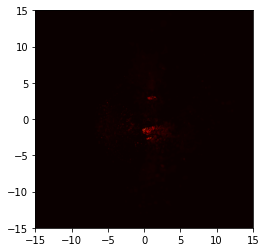

In [35]:
# Plot one image only
import analyze_r3d_functions as a3d
import matplotlib.pyplot as plt
import numpy as np

# Useful numbers
c = 2.998e8 # speed of light in m/s
pc = 30.857e15 # 1 parsec in m
AUcm = 1.49598e13 # AU in cm
kboltz = 1.3806503e-23 # Boltzmann constant in Si
hplanck = 6.626068e-34 # Planck constant in Si

# Definitions
path = '../r3dresults/st28gm06n052_nospikes/166_nogas/'
image = 'image_i000_phi000_0.65um.out'
distance = 1

# Chose polarisation
#polarisation = 'i'   # Should be the normal image
polarisation = 'q'   # lin1
#polarisation = 'u'   # lin2
#polarisation = 'v'   # circ

# TODO
# should be able to combine q and u for all linear polarised light

# Set column number
if polarisation == 'i':
    polar_numb = 0
if polarisation == 'q':
    polar_numb = 1
if polarisation == 'u':
    polar_numb = 2
if polarisation == 'v':
    polar_numb = 3

# Place holder for total flux density
fluxtotal = []

# Load image
# TODO save this image-loader as special polarised light loader!

# Automatically add / to end of path if it's missing
if path[-1] != '/':
    path += '/'

# Declare lists
image1d = []

# Load data
with open(path+image, 'r') as f:
    for nl,line in enumerate(f.readlines()):

        # Check if polarised image or not
        if nl == 0:
            imagesetting = int(line.strip())
        if imagesetting == 3:
            # This is correct, otherwise, load normal image
            #            
            # Row 1: image size, pixels by pixels
            if nl == 1:
                npixels_x = int(line.split()[0])
                npixels_y = int(line.split()[1])
                npixels = max([npixels_x,npixels_y])            
            # row 3: pixel size is in cm, divide by AUcm for AU
            if nl == 3:
                pixelsize_au = float(line.split()[0])/AUcm


            # row 6 onward: pixel-values, four columns
            # image.out's pixels has unit
            # erg s-1 cm-2 Hz-1 ster-1
            if nl > 5:
                if len(line.split()) > 1:
                    # Split line and take the chosen column
                    pixeldata = line.split()[polar_numb]

                    # Some rows are empty or contain space and \n, so strip them pixel data
                    # and save in image1d
                    if len(line.strip()) > 0:
                        image1d.append(float(pixeldata.strip()))

if imagesetting == 1:
    print('Not polarised, load normal image with a3d.load_images()!')
    # TODO do that here
else:
    # Continue with plotting image
    #
    # Extract some useful quantities
    # pixel size in asec (pixelsize in au and distance in pc gives distance in asec)
    pixelsize_as = pixelsize_au / distance
    #
    # Size of whole image in AU and image-axis-scales
    size_au = pixelsize_au * npixels
    axisplot  = [-0.5*size_au,0.5*size_au,-0.5*size_au,0.5*size_au]
    #
    # Extract intensity of component
    if polarisation != 'i':
        image1d = [np.abs(image1dpix) for image1dpix in image1d]
    #
    # Total flux density of the image in Jy
    # Transoform to Jy/pix and sum all
    # 1 Jy = 1e23 erg/(s cm2 Hz)
    # 1 asec = 1/(180/pi * 3600)^2 ster = 2.35044305391e-11 ster
    # 1 pixel = pixelsize_as^2  asec^2
    totalflux = sum(image1d) * 1.e23 * 2.35044305391e-11 * pixelsize_as**2
    #
    # Create 2D arrays
    image2d = np.zeros((npixels,npixels))
    image2dlog = np.zeros((npixels,npixels))
    nx,ny = 0,0
    #
    for flux in image1d:
        # Convert image1d to 2d and change unit to Jy/asec2
        image2d[nx,ny] = flux * 1.e23 * 2.35044305391e-11
        #   
        # Remove zeros before logging (1e-6 is small enough, probably)
        # Smallest number >0 is 1.1, so log10 is just larger than 0
        if image2d[nx,ny] == 0:
            image2dlog[nx,ny] = -6
        else:
            image2dlog[nx,ny] = np.log10(flux * 1.e23 * 2.35044305391e-11)
        #
        # Move nx and ny
        nx = nx + 1
        if nx == npixels_x:
            nx = 0
            ny = ny + 1
    # 
    # TODO here ends Load-image-code
    #      now we start plot-image code
    #
    vmin = np.min(image2d)
    vmax = np.max(image2d)
    plt.imshow(
        image2d,
        origin='lower',
        extent=axisplot,
        cmap=plt.get_cmap('hot'),
        vmin=vmin,
        vmax=vmax
    )



"""

, origin='lower', extent=axisplot, cmap=plt.get_cmap('hot'),
        vmin=vmin,
        vmax=vmax

        
        
    # Plot each image (one in linear and one log)
    fig, ax = plt.subplots(
        1,2, 
        dpi = 150, 
        num = path+image
    )
    
    im0 = ax[0].imshow(
        image2d, origin='lower', extent=axisplot, cmap=plt.get_cmap('hot')
    )
    ax[0].set(
        title=f"{path[-4:-1]}: {image.replace('image_', '').replace('.out', '')} (Lin)", 
        xlabel='Offset (AU)',
        ylabel='Offset (AU)'
    )
            
    ax[1].imshow(
        image2dlog, origin='lower', extent=axisplot, cmap=plt.get_cmap('hot')
    )
    ax[1].set(
        title=f"{path[-4:-1]}: {image.replace('image_', '').replace('.out', '')} (Log)", 
        xlabel='Offset (AU)',
    )

    #cb0 = plt.colorbar(im0, orientation = 'vertical',shrink=0.4,pad=0.15)
    #cb0.set_label(label = rf'Flux at {distance} pc (Jy/asec$^2$)',fontsize= 10)

    # Change figure size
fig.tight_layout()

""";



In [26]:
vmin

np.float64(5.943541282271849e-20)